<a href="https://colab.research.google.com/github/Abitharani-Jeyachandran/Abitharani-Jeyachandran/blob/main/GarbageFinal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os

In [22]:
data_path = "/content/drive/MyDrive/Colab Notebooks/train-data"
label_dict = { "glass": 0, "metal": 1, "plastic": 2 }
directories = os.listdir(data_path)

In [23]:
import cv2

In [5]:
dataset = []
corrupted_imgs = 0

for directory in directories:
    dir_path = os.path.join(data_path, directory)
    img_files = os.listdir(dir_path)

    for img_file in img_files:
        img_file_path = os.path.join(dir_path, img_file)
        
        try:
            image = cv2.imread(img_file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (50, 50))

            dataset.append([image, label_dict[directory]])
        except Exception:
            corrupted_imgs += 1

In [6]:
len(dataset)

12725

In [7]:
corrupted_imgs

8

In [8]:
from random import shuffle

shuffle(dataset)

In [9]:
data = []
target = []

for feature, label in dataset:
    data.append(feature)
    target.append(label)

In [10]:
import numpy as np
from keras.utils import np_utils

data = np.asarray(data) / 255.0
data = np.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))

target = np.asarray(target)
target = np_utils.to_categorical(target)

In [11]:
print(data.shape)
print(target.shape)

(12725, 50, 50, 1)
(12725, 3)


In [12]:
np.save("data.npy", data)
np.save("target.npy", target)

In [13]:
import numpy as np

In [14]:
data = np.load("data.npy")
target = np.load("target.npy")

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout

In [16]:
from matplotlib import pyplot as plt

In [17]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    data,
    target,
    test_size=0.2
)

In [18]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(10180, 50, 50, 1) (10180, 3)
(2545, 50, 50, 1) (2545, 3)


In [19]:
from keras.callbacks import ModelCheckpoint

In [36]:
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(16, (3, 3), input_shape=data.shape[1:], padding="same", kernel_initializer="orthogonal"))
model.add(Activation("relu"))

# Add a max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))

# Add a second max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add two more convolutional layers
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))

# Add a second max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add a dense layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Add the output layer
model.add(Dense(3, activation='softmax'))
          
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 50, 50, 16)        160       
                                                                 
 activation_14 (Activation)  (None, 50, 50, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 23, 23, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 9, 9, 64)         

In [38]:
val_loss_checkpoint_callback = ModelCheckpoint(
    filepath="val_loss_model1.{epoch:03d}-{loss:.4f}-{val_loss:.4f}.h5",
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_best_only=True
)

val_acc_checkpoint_callback = ModelCheckpoint(
    filepath="loss_model1.{epoch:03d}-{loss:.4f}-{val_loss:.4f}.h5",
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True
)

In [39]:
from keras.preprocessing.image import ImageDataGenerator

train_test_img_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode="wrap",
)

In [40]:
train_test_img_generator.fit(train_data)

In [41]:
train_batch_size = 20
validation_batch_size = 10

history = model.fit(
    train_test_img_generator.flow(train_data, train_labels, shuffle=True, batch_size=train_batch_size),
    validation_data=(test_data, test_labels),
    epochs=100,
    steps_per_epoch=len(train_data) // train_batch_size,
    callbacks=[val_loss_checkpoint_callback, val_acc_checkpoint_callback]
)

Epoch 1/100
509/509 [==============================] - 53s 100ms/step - loss: 1.0419 - accuracy: 0.4911 - val_loss: 0.9777 - val_accuracy: 0.5363
Epoch 2/100
509/509 [==============================] - 55s 107ms/step - loss: 1.0062 - accuracy: 0.5066 - val_loss: 0.9712 - val_accuracy: 0.5446
Epoch 3/100
509/509 [==============================] - 50s 99ms/step - loss: 0.9768 - accuracy: 0.5264 - val_loss: 1.0106 - val_accuracy: 0.4892
Epoch 4/100
509/509 [==============================] - 50s 98ms/step - loss: 0.9581 - accuracy: 0.5428 - val_loss: 0.9313 - val_accuracy: 0.5678
Epoch 5/100
509/509 [==============================] - 50s 98ms/step - loss: 0.9462 - accuracy: 0.5531 - val_loss: 0.9493 - val_accuracy: 0.5407
Epoch 6/100
509/509 [==============================] - 50s 99ms/step - loss: 0.9386 - accuracy: 0.5540 - val_loss: 0.9291 - val_accuracy: 0.5737
Epoch 7/100
509/509 [==============================] - 48s 95ms/step - loss: 0.9256 - accuracy: 0.5678 - val_loss: 0.9021 - val_

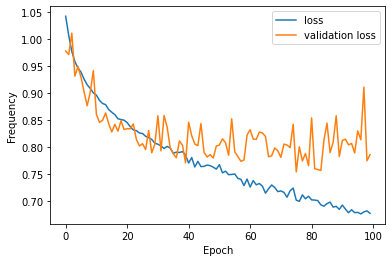

In [42]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Frequency")
plt.show()

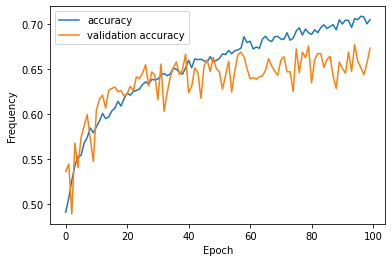

In [43]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Frequency")
plt.show()

In [44]:
model.load_weights("val_loss_model1.076-0.7023-0.7545.h5")

In [45]:
loss, acc = model.evaluate(test_data, test_labels)
print(loss, acc)

80/80 [==============================] - 3s 40ms/step - loss: 0.7545 - accuracy: 0.6727
0.7544810175895691 0.6726915240287781


In [46]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

80/80 [==============================] - 3s 30ms/step


In [47]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)
print(confusion)

[[340 121 190]
 [ 58 437 130]
 [119 215 935]]


In [48]:
import seaborn as sn
import pandas as pd

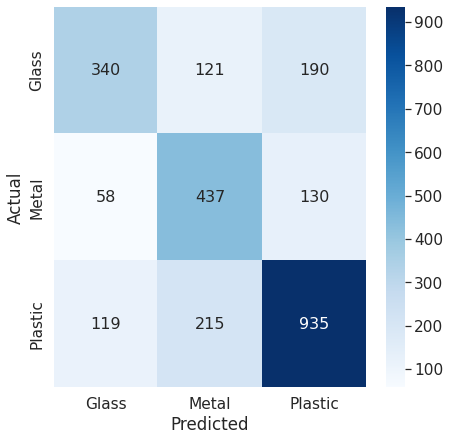

In [50]:
df_cm = pd.DataFrame(confusion, columns=np.unique(["Glass", "Metal","Plastic"]), index = np.unique(["Glass", "Metal","Plastic"]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")# for font size

In [51]:
df_cm

Predicted,Glass,Metal,Plastic
Actual,,,
Glass,340,121,190
Metal,58,437,130
Plastic,119,215,935


In [52]:
print("Prediction accuracy for class Glass: ", (confusion[0][0] / np.sum(confusion[0])) * 100)
print("Prediction accuracy for class Metal: ", (confusion[1][1] / np.sum(confusion[1])) * 100)
print("Prediction accuracy for class Metal: ", (confusion[2][2] / np.sum(confusion[2])) * 100)
print("Overall accuracy: ", ((confusion[0][0] + confusion[1][1] + confusion[2][2]) / (np.sum(confusion))) * 100)

Prediction accuracy for class Glass:  52.22734254992319
Prediction accuracy for class Metal:  69.92
Prediction accuracy for class Metal:  73.68006304176517
Overall accuracy:  67.26915520628684


In [53]:
import cv2
import os

In [54]:
test_img_root = "/content/drive/MyDrive/Colab Notebooks/garbage/test"
img_files = os.listdir(test_img_root)
labels = {0: "Glass", 1: "Metal", 2: "Plastic"}

In [55]:
images = []
orig_images = []

for img_file in img_files:
    img_path = os.path.join(test_img_root, img_file)
    orig_image = cv2.imread(img_path)
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (50, 50))
    
    orig_images.append(cv2.resize(orig_image, (100, 100)))
    images.append(image)
    
images = np.asarray(images)
orig_images = np.asarray(orig_images)

In [56]:
predictions = []

for image in images:
    image = image / 255
    image = np.reshape(image, (1, 50, 50, 1))
    prediction = model.predict(image)
    arg_max = np.argmax(prediction, axis=1)[0]
    label = labels[arg_max]
    predictions.append((label, prediction[0][arg_max]))

1/1 [==============================] - 0s 26ms/step


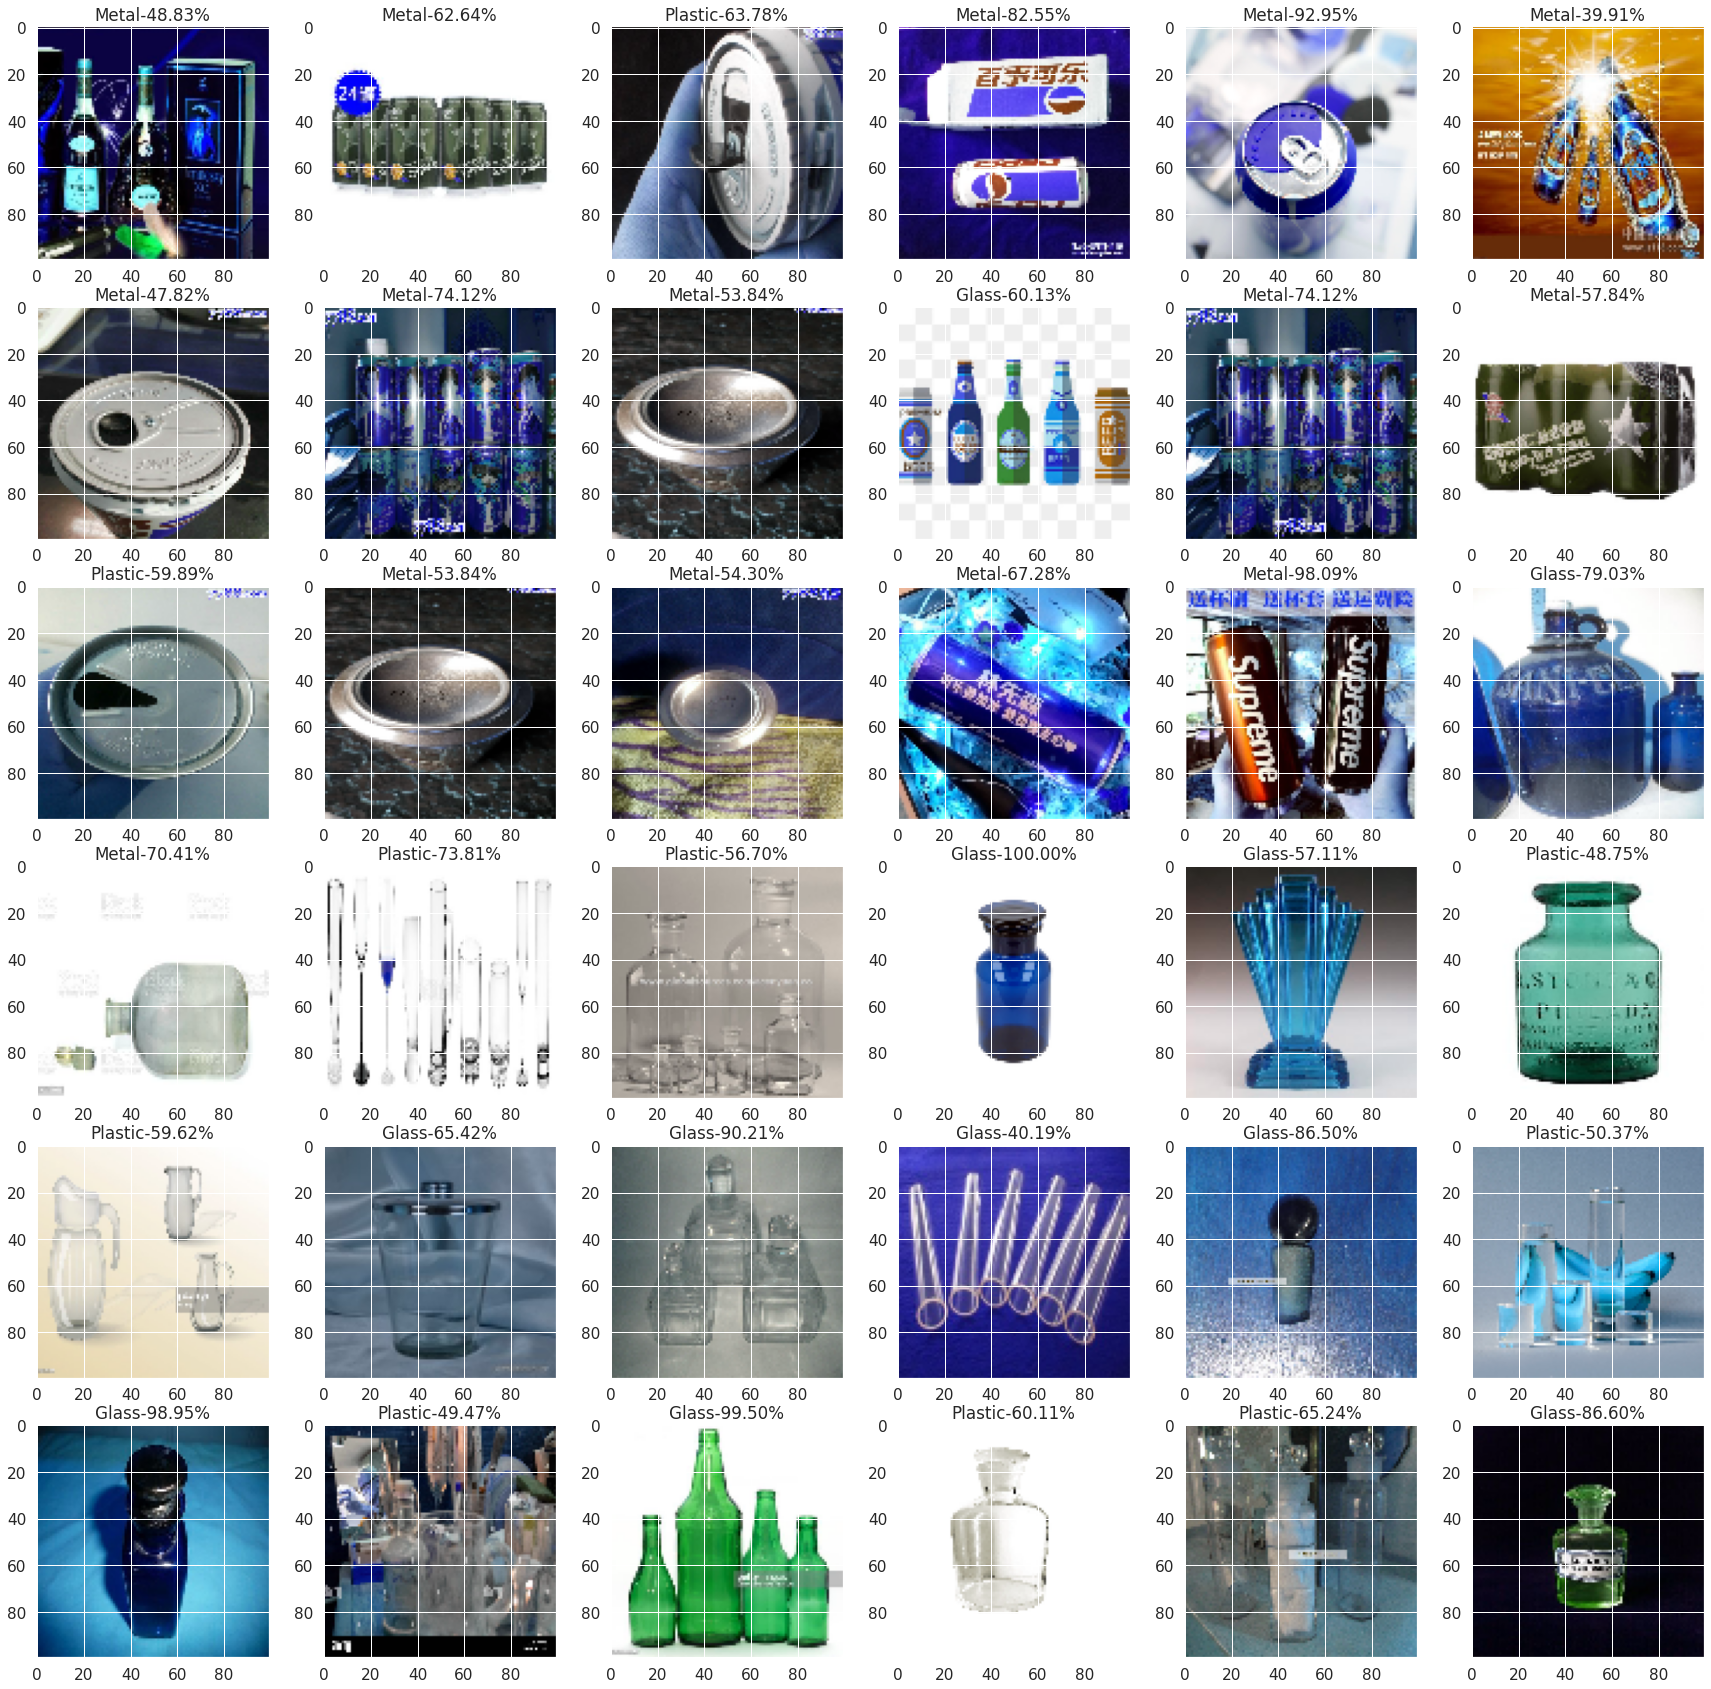

In [57]:
figure = plt.figure(figsize=(30, 30))
cols = 6
rows = 6

for i in range(cols * rows):
    image = orig_images[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(predictions[i][0] + "-" + "{0:.2f}%".format(predictions[i][1] * 100))
    plt.imshow(image)
plt.show()

In [58]:
model.save_weights("model_weights.h5")
model.save('garbage-keras-model.h5')
from google.colab import files
files.download('garbage-keras-model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>